In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [2]:
data =  pd.read_csv('/content/sorted_temp_and_rain_dataset.csv', header=0)
train_percent=0.60
num_epochs=150

In [3]:
data.head()

,Year,Rain
0,1-Jan-01,18.5356
1,1-Feb-01,16.2548
2,1-Mar-01,70.7981
3,1-Apr-01,66.1616
4,1-May-01,267.2150


In [4]:
print(len(data['Rain'].unique()))
symbols = data['Rain'].unique()

1473


In [5]:
data['Rain'].describe()

count    1474.000000
mean      202.817120
std       200.780134
min         0.000000
25%        19.382328
50%       146.412000
75%       347.571000
max      1012.020000
Name: Rain, dtype: float64

In [6]:
#random.seed(42)  #explain!
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

442.622


In [7]:
data_mod = data.drop(['Year'], axis=1)

In [8]:
data_mod

,Rain
0,18.535600
1,16.254800
2,70.798100
3,66.161600
4,267.215000
...,...
1469,299.915166
1470,353.399033
1471,421.058714
1472,306.090925


In [9]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_mod_scaled = sc.fit_transform(data_mod)

In [10]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [11]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_mod_scaled, n_future=1, n_past=25, train_test_split_percentage=train_percent,
                                               validation_split_percentage = 0)


In [12]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(869, 25, 1)
(580, 25, 1)
(869, 1)
(580, 1)


In [13]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64)
#history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64, callbacks=[es])

Epoch 1/150
10/10 [==============================] - 7s 100ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2051
Epoch 2/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0490 - root_mean_squared_error: 0.2214 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2019
Epoch 3/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1986
Epoch 4/150
10/10 [==============================] - 0s 10ms/step - loss: 0.0463 - root_mean_squared_error: 0.2152 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 5/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1933
Epoch 6/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0440 - root_mean_squared_error: 0.2098 - val_loss: 0.0364 - val

In [15]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

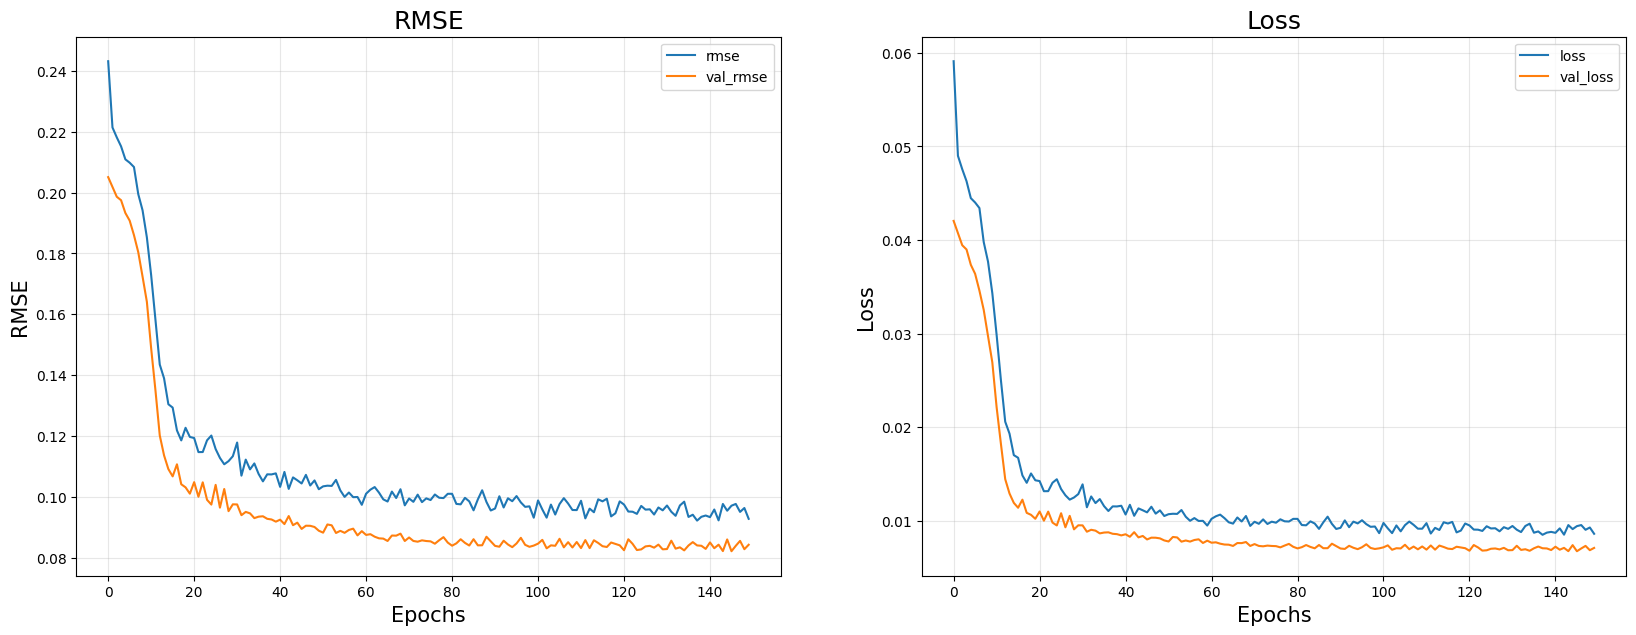

In [16]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [17]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

19/19 [==============================] - 0s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840
test loss, test acc: [0.0071 0.084 ]


In [18]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
from keras.layers import Bidirectional , GRU

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es, mc], verbose=1)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [19]:
config = [[False], [False], [False], [8,16, 32, 64, 128], [8, 16, 32, 64, 128], [0.2,0.3,0.5]]
# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 8, 8, 0.2), (False, False, False, 8, 8, 0.3), (False, False, False, 8, 8, 0.5), (False, False, False, 8, 16, 0.2), (False, False, False, 8, 16, 0.3), (False, False, False, 8, 16, 0.5), (False, False, False, 8, 32, 0.2), (False, False, False, 8, 32, 0.3), (False, False, False, 8, 32, 0.5), (False, False, False, 8, 64, 0.2), (False, False, False, 8, 64, 0.3), (False, False, False, 8, 64, 0.5), (False, False, False, 8, 128, 0.2), (False, False, False, 8, 128, 0.3), (False, False, False, 8, 128, 0.5), (False, False, False, 16, 8, 0.2), (False, False, False, 16, 8, 0.3), (False, False, False, 16, 8, 0.5), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 16, 0.3), (False, False, False, 16, 16, 0.5), (False, False, False, 16, 32, 0.2), (False, False, False, 16, 32, 0.3), (False, False, False, 16, 32, 0.5), (False, False, False, 16, 64, 0.2), (False, False, False, 16, 64, 0.3), (False, False, False, 16, 64, 0.5), (False, False, False, 16, 128, 0.2), (False, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
 7/10 [====================>.........] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0985
Epoch 41: val_loss improved from 0.00783 to 0.00757, saving model to best_model.h5
10/10 [==============================] - 0s 23ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 42/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1017
Epoch 42: val_loss did not improve from 0.00757
10/10 [==============================] - 0s 19ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 43/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.1002
Epoch 43: val_loss did not improve from 0.00757
10/10 [==============================] - 0s 19ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0088 - val_ro

In [20]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
32,False,False,False,32,8,0.5,"[0.007694968022406101, 0.08772096782922745]","[0.006903793662786484, 0.08308906853199005]"
67,False,False,False,128,32,0.3,"[0.0077314600348472595, 0.08792871981859207]","[0.007010344881564379, 0.08372779935598373]"
53,False,False,False,64,32,0.5,"[0.008021445944905281, 0.08956252783536911]","[0.007085000164806843, 0.08417244255542755]"
17,False,False,False,16,8,0.5,"[0.008452835492789745, 0.0919393002986908]","[0.007168525829911232, 0.0846671462059021]"
66,False,False,False,128,32,0.2,"[0.007901370525360107, 0.08888965100049973]","[0.0071823070757091045, 0.08474849164485931]"
...,...,...,...,...,...,...,...,...
3,False,False,False,8,16,0.2,"[0.00915499497205019, 0.09568173438310623]","[0.009554464370012283, 0.09774693846702576]"
46,False,False,False,64,8,0.3,"[0.009974365122616291, 0.09987174719572067]","[0.010186572559177876, 0.10092855244874954]"
14,False,False,False,8,128,0.5,"[0.010753963142633438, 0.10370131582021713]","[0.010227597318589687, 0.10113158077001572]"
13,False,False,False,8,128,0.3,"[0.011786270886659622, 0.108564592897892]","[0.011653979308903217, 0.10795360058546066]"


In [21]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.5
**************************
Results Before Tunning:
 Test Set RMSE: 0.084

Results After Tunning:
 Test Set RMSE: 0.0831

1.0% Improvement


In [22]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [23]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, verbose=1)
#history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es], verbose=1)

Epoch 1/150
76/76 [==============================] - 5s 20ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1967
Epoch 2/150
76/76 [==============================] - 1s 8ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706
Epoch 3/150
76/76 [==============================] - 1s 8ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 4/150
76/76 [==============================] - 1s 8ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 5/150
76/76 [==============================] - 1s 8ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 6/150
76/76 [==============================] - 1s 8ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.0091 - val_root_

In [24]:
regressor.evaluate(X_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871


[0.007591619156301022, 0.08712989836931229]

In [25]:
history_2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

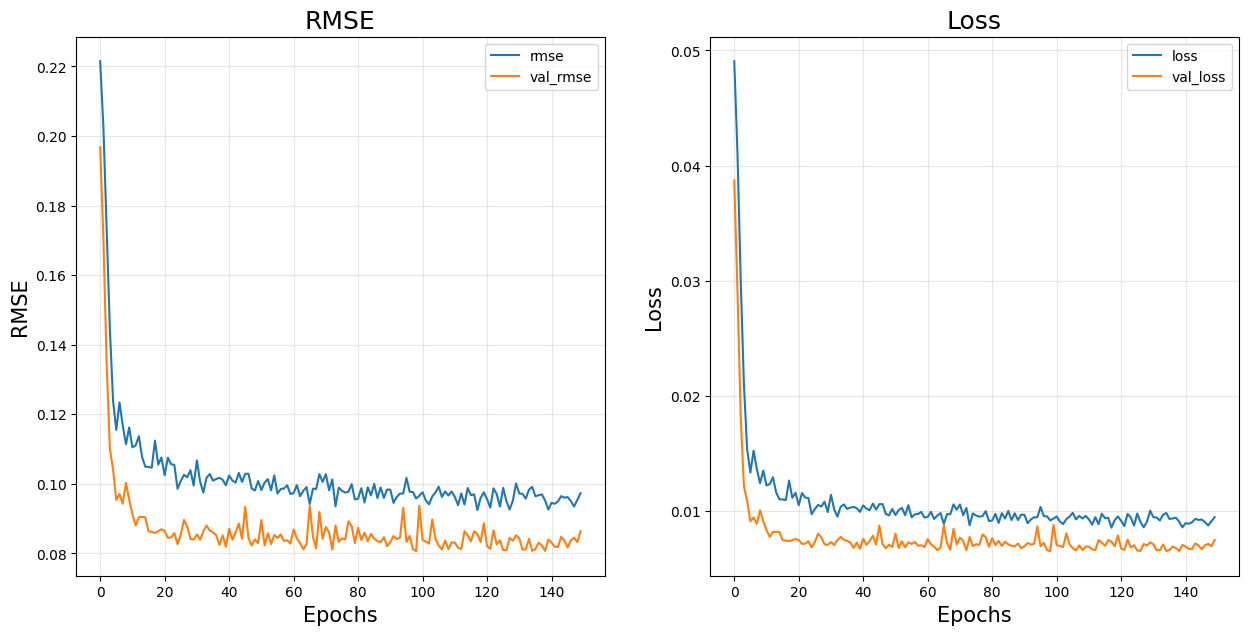

In [26]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history_2.epoch, history_2.history['root_mean_squared_error'], label = "rmse")
plt.plot(history_2.epoch, history_2.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history_2.epoch, history_2.history['loss'], label="loss")
plt.plot(history_2.epoch, history_2.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

19/19 [==============================] - 1s 3ms/step


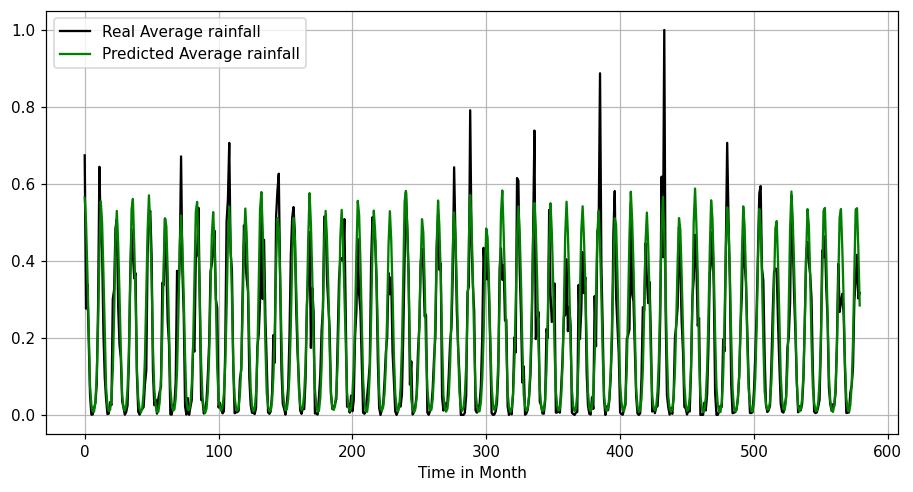

In [27]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
plt.plot(y_test, color='black', label = 'Real Average rainfall')
plt.plot(y_pred, color='green', label = 'Predicted Average rainfall')
plt.legend(loc='best')
plt.xlabel('Time in Month')
plt.grid(alpha=0.9)
plt.legend()


19/19 [==============================] - 0s 4ms/step


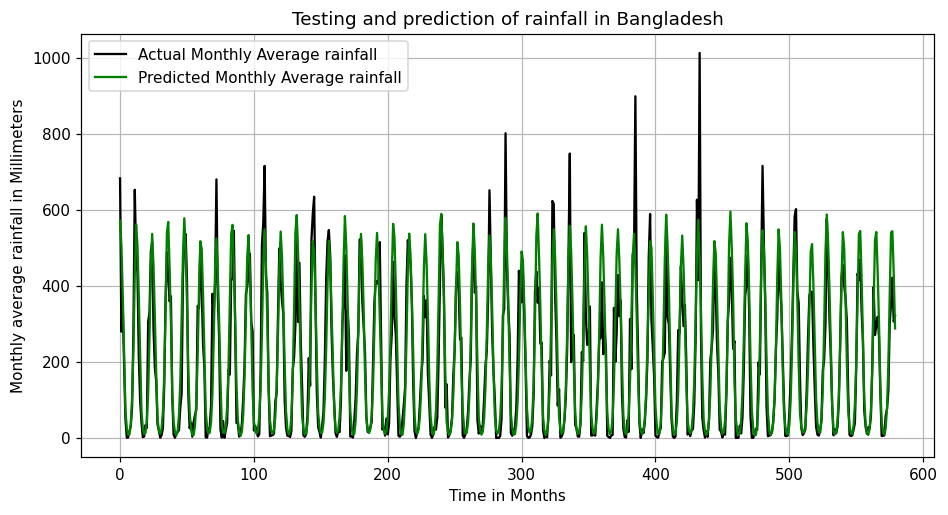

In [28]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
y_test_sc = sc.inverse_transform(y_test)
y_pred_sc = sc.inverse_transform(y_pred)
plt.plot(y_test_sc, color='black', label = 'Actual Monthly Average rainfall')
plt.plot(y_pred_sc, color='green', label = 'Predicted Monthly Average rainfall')
plt.legend(loc='best')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.xlabel('Time in Months')
plt.ylabel('Rain')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Testing and prediction of rainfall in Bangladesh')
plt.grid(alpha=0.9)
plt.legend()

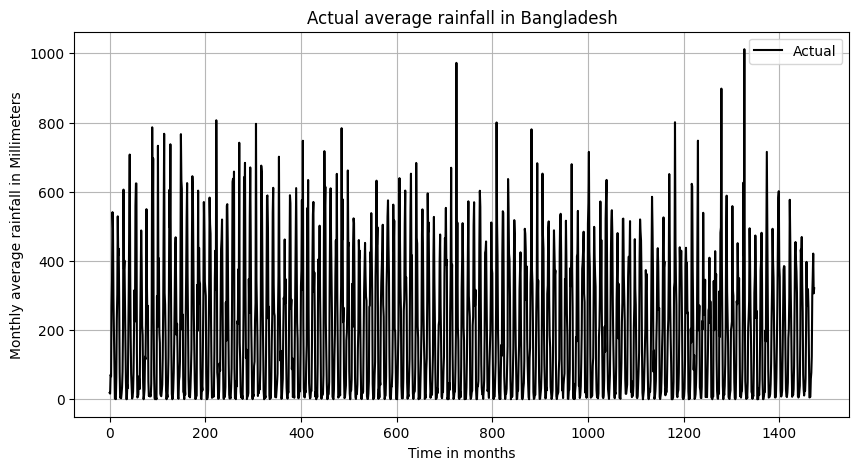

In [29]:
plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(data['Rain'], color='black', label = 'Actual')
plt.grid(alpha=0.9)
plt.xlabel('Time in months')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Actual average rainfall in Bangladesh')
plt.legend(loc='best')

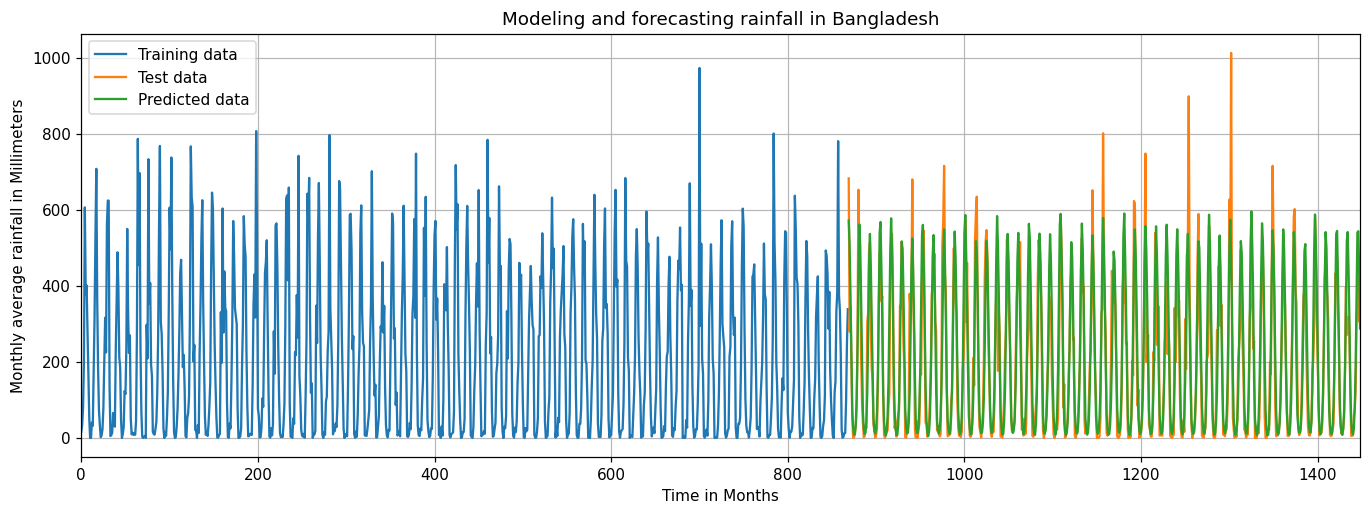

In [30]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.legend()
plt.xlabel('Time in Months')
plt.ylabel('Rain')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Modeling and forecasting rainfall in Bangladesh')
plt.legend(loc='best')
plt.grid(alpha=0.9)
plt.xlim([min(time_train), max(time_test)])
plt.grid(alpha=0.9)
plt.show()

In [31]:
# set x_forcast to be the input data
x_forcast = X_test[-1::]
y_forcast = []
n_forecast=240
for _ in range(n_forecast):

    # predict y values with the regression model
    y_forcast_temp = regressor.predict(x_forcast)
    x_forcast = np.append(x_forcast[:,1:,:], np.array(y_forcast_temp).reshape(1,1,1), axis=1)


    # append the y_forcast to the end of x_forcast
    y_forcast.append(y_forcast_temp.reshape(1))


1/1 [==============================] - 0s 20ms/step


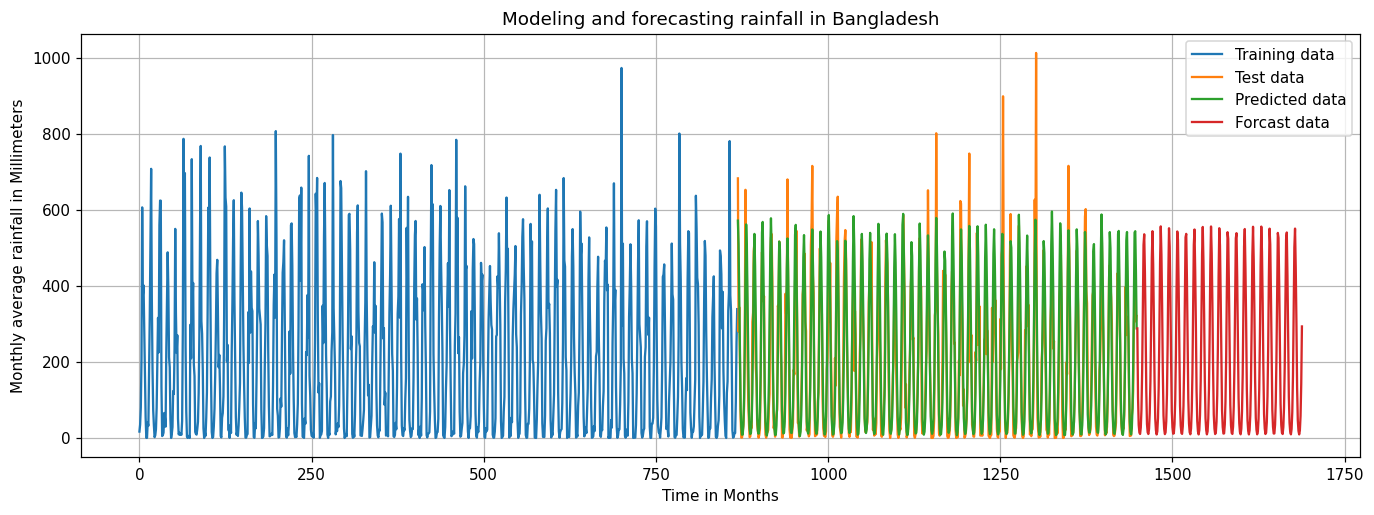

In [32]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
time_forecast = range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_forcast))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.plot(time_forecast, sc.inverse_transform(y_forcast), label='Forcast data')
plt.legend()
plt.xlabel('Time in Months')
plt.ylabel('Rain')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Modeling and forecasting rainfall in Bangladesh')
plt.legend(loc='best')
plt.grid(alpha=0.9)
# plt.xlim([min(time_train), max(time_forecast)])
plt.grid(alpha=0.9)
plt.show()

In [33]:
X_train.shape

(869, 25, 1)

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test_sc, y_pred_sc)
mae = mean_absolute_error(y_test_sc, y_pred_sc)
mape = mean_absolute_percentage_error(y_test_sc, y_pred_sc)*100
r2_Squared = r2_score(y_test_sc, y_pred_sc)
rmse = np.sqrt(mse)
rrmse= np.sqrt(rmse)
print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
#print(f'X_test RMSLE: {rmsle}')
print(f'R-Squared: {r2_Squared}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RRMSE: {rrmse}')

X_test MSE: 7775.218994409389
X_test MAE: 60.712345355866574
X_test MAPE:11851.285728300869%
R-Squared: 0.7841279321880592
X_test RMSE: 88.17720223736626
X_test RRMSE: 9.390271680700526
